In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load the dataset
df = pd.read_csv('final_unclean.csv')

print("Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nMissing Values:")
print(df.isnull().sum())

# Display basic info
print("\nData Types:")
print(df.dtypes)

Dataset Overview:
Shape: (1175, 14)
Columns: ['Country Name', 'ISO3', 'Year', 'HDI', 'Suicide_rate', 'GDP_per_capita', 'log_GDP_per_capita', 'income_group_auto', 'continent', 'Low_data_quality_flag', 'HDI_sq', 'Suicide_rate_lag1', 'HDI_lag1', 'Low_data_quality_flag_panel']

Missing Values:
Country Name                     0
ISO3                             0
Year                             0
HDI                             28
Suicide_rate                   764
GDP_per_capita                  32
log_GDP_per_capita              32
income_group_auto               32
continent                       32
Low_data_quality_flag           32
HDI_sq                          28
Suicide_rate_lag1              777
HDI_lag1                       220
Low_data_quality_flag_panel      0
dtype: int64

Data Types:
Country Name                    object
ISO3                            object
Year                             int64
HDI                            float64
Suicide_rate                   float6

In [5]:
# Step 1: Initial Data Exploration and Understanding
def explore_dataset(df):
    print("=== DATASET EXPLORATION ===")
    print(f"Total countries: {df['Country Name'].nunique()}")
    print(f"Time period: {df['Year'].min()} - {df['Year'].max()}")
    print(f"Continents: {df['continent'].unique()}")
    print(f"Income groups: {df['income_group_auto'].unique()}")
    
    # Check data quality flags
    print(f"\nData Quality Distribution:")
    print("Low_data_quality_flag:")
    print(df['Low_data_quality_flag'].value_counts(dropna=False))
    print("\nLow_data_quality_flag_panel:")
    print(df['Low_data_quality_flag_panel'].value_counts(dropna=False))
    
    return df

df = explore_dataset(df)

=== DATASET EXPLORATION ===
Total countries: 205
Time period: 2010 - 2023
Continents: ['Asia' 'Africa' 'Europe' 'America' nan 'Oceania']
Income groups: ['Low' 'Lower-Middle' 'High' 'Upper-Middle' nan]

Data Quality Distribution:
Low_data_quality_flag:
Low_data_quality_flag
✅ Sufficient data          1066
⚠️ Low data reliability      77
NaN                          32
Name: count, dtype: int64

Low_data_quality_flag_panel:
Low_data_quality_flag_panel
⚠️ Low data reliability    792
✅ Sufficient data          383
Name: count, dtype: int64


In [6]:
# Step 2: Ethical Data Cleaning Strategy - FIXED VERSION

def ethical_cleaning(df):
    """
    Clean dataset with ethical considerations:
    - Preserve all records
    - Use appropriate imputation methods
    - Maintain data integrity
    - Document all transformations
    """
    
    df_clean = df.copy()
    
    # 1. Handle obvious data errors
    # Malawi has an extreme suicide rate value (837.0) - likely data entry error
    malawi_mask = (df_clean['Country Name'] == 'Malawi') & (df_clean['Suicide_rate'] > 100)
    df_clean.loc[malawi_mask, 'Suicide_rate'] = np.nan
    
    print("Fixed extreme values in Malawi suicide rate")
    
    # 2. Convert data quality flags to binary for easier handling - FIXED
    # First, fill NaN values with a default value
    df_clean['Low_data_quality_flag'] = df_clean['Low_data_quality_flag'].fillna('✅ Sufficient data')
    df_clean['Low_data_quality_flag_panel'] = df_clean['Low_data_quality_flag_panel'].fillna('✅ Sufficient data')
    
    # Now safely convert to binary
    df_clean['data_quality_issue'] = df_clean['Low_data_quality_flag'].str.contains('⚠️').fillna(False).astype(int)
    df_clean['panel_data_quality_issue'] = df_clean['Low_data_quality_flag_panel'].str.contains('⚠️').fillna(False).astype(int)
    
    # 3. Create comprehensive data quality score (0 = best, 2 = worst)
    df_clean['data_quality_score'] = df_clean['data_quality_issue'] + df_clean['panel_data_quality_issue']
    
    print(f"Data quality scores distribution:")
    print(df_clean['data_quality_score'].value_counts().sort_index())
    
    return df_clean

df_clean = ethical_cleaning(df)

Fixed extreme values in Malawi suicide rate
Data quality scores distribution:
data_quality_score
0    361
1    759
2     55
Name: count, dtype: int64


In [7]:
# Step 3: Advanced Missing Value Imputation

def advanced_imputation(df_clean):
    """
    Use multiple imputation strategies based on data characteristics
    """
    
    df_imputed = df_clean.copy()
    
    # Strategy 1: For suicide rates - use country-specific patterns and regional averages
    print("Imputing missing suicide rates...")
    
    # Calculate regional and income group averages
    regional_avg = df_imputed.groupby(['continent', 'Year'])['Suicide_rate'].transform('mean')
    income_avg = df_imputed.groupby(['income_group_auto', 'Year'])['Suicide_rate'].transform('mean')
    country_avg = df_imputed.groupby('Country Name')['Suicide_rate'].transform('mean')
    
    # For countries with no suicide rate data, use a hierarchical approach
    df_imputed['Suicide_rate_initial'] = df_imputed['Suicide_rate'].copy()
    
    # Fill missing values hierarchically: country avg -> regional avg -> income group avg -> global avg
    suicide_missing = df_imputed['Suicide_rate_initial'].isnull()
    
    # Step 1: Fill with country average (if available)
    country_fill = df_imputed.groupby('Country Name')['Suicide_rate_initial'].transform(
        lambda x: x.fillna(x.mean()))
    df_imputed.loc[suicide_missing, 'Suicide_rate_initial'] = country_fill[suicide_missing]
    
    # Step 2: Fill remaining with regional average
    suicide_missing = df_imputed['Suicide_rate_initial'].isnull()
    regional_fill = df_imputed.groupby(['continent', 'Year'])['Suicide_rate_initial'].transform(
        lambda x: x.fillna(x.mean()))
    df_imputed.loc[suicide_missing, 'Suicide_rate_initial'] = regional_fill[suicide_missing]
    
    # Step 3: Fill remaining with income group average
    suicide_missing = df_imputed['Suicide_rate_initial'].isnull()
    income_fill = df_imputed.groupby(['income_group_auto', 'Year'])['Suicide_rate_initial'].transform(
        lambda x: x.fillna(x.mean()))
    df_imputed.loc[suicide_missing, 'Suicide_rate_initial'] = income_fill[suicide_missing]
    
    # Step 4: Fill any remaining with global average by year
    suicide_missing = df_imputed['Suicide_rate_initial'].isnull()
    global_fill = df_imputed.groupby('Year')['Suicide_rate_initial'].transform(
        lambda x: x.fillna(x.mean()))
    df_imputed.loc[suicide_missing, 'Suicide_rate_initial'] = global_fill[suicide_missing]
    
    # Use the imputed values
    df_imputed['Suicide_rate_final'] = df_imputed['Suicide_rate_initial']
    
    # Strategy 2: For HDI - use linear interpolation within countries
    print("Imputing missing HDI values...")
    df_imputed['HDI_imputed'] = df_imputed.groupby('Country Name')['HDI'].transform(
        lambda x: x.interpolate(method='linear', limit_direction='both')
    )
    
    # For countries with no HDI data, use hierarchical approach
    hdi_missing = df_imputed['HDI_imputed'].isnull()
    
    # Fill with regional averages
    hdi_regional_avg = df_imputed.groupby(['continent', 'Year'])['HDI_imputed'].transform('mean')
    df_imputed.loc[hdi_missing, 'HDI_imputed'] = hdi_regional_avg[hdi_missing]
    
    # Fill any remaining with income group averages
    hdi_missing = df_imputed['HDI_imputed'].isnull()
    hdi_income_avg = df_imputed.groupby(['income_group_auto', 'Year'])['HDI_imputed'].transform('mean')
    df_imputed.loc[hdi_missing, 'HDI_imputed'] = hdi_income_avg[hdi_missing]
    
    # Final fill with global averages
    hdi_missing = df_imputed['HDI_imputed'].isnull()
    hdi_global_avg = df_imputed.groupby('Year')['HDI_imputed'].transform('mean')
    df_imputed.loc[hdi_missing, 'HDI_imputed'] = hdi_global_avg[hdi_missing]
    
    df_imputed['HDI_final'] = df_imputed['HDI_imputed']
    
    # Strategy 3: For lag variables - calculate based on final imputed values
    df_imputed['Suicide_rate_lag1_final'] = df_imputed.groupby('Country Name')['Suicide_rate_final'].shift(1)
    df_imputed['HDI_lag1_final'] = df_imputed.groupby('Country Name')['HDI_final'].shift(1)
    
    # Recalculate HDI squared with imputed values
    df_imputed['HDI_sq_final'] = df_imputed['HDI_final'] ** 2
    
    print("Imputation completed successfully!")
    print(f"Missing values after imputation:")
    print(f"Suicide_rate_final: {df_imputed['Suicide_rate_final'].isnull().sum()}")
    print(f"HDI_final: {df_imputed['HDI_final'].isnull().sum()}")
    
    return df_imputed

df_imputed = advanced_imputation(df_clean)

Imputing missing suicide rates...
Imputing missing HDI values...
Imputation completed successfully!
Missing values after imputation:
Suicide_rate_final: 0
HDI_final: 0


In [8]:
# Step 4: Create Derived Features for Analysis

def create_derived_features(df_imputed):
    """
    Create features that will help in exploring the "Price of Progress" theme
    """
    
    df_enhanced = df_imputed.copy()
    
    # 1. Development categories based on HDI
    conditions = [
        df_enhanced['HDI_final'] < 0.55,
        (df_enhanced['HDI_final'] >= 0.55) & (df_enhanced['HDI_final'] < 0.7),
        (df_enhanced['HDI_final'] >= 0.7) & (df_enhanced['HDI_final'] < 0.8),
        df_enhanced['HDI_final'] >= 0.8
    ]
    choices = ['Low Development', 'Medium Development', 'High Development', 'Very High Development']
    df_enhanced['development_category'] = np.select(conditions, choices, default='Unknown')
    
    # 2. Suicide rate categories
    suicide_conditions = [
        df_enhanced['Suicide_rate_final'] < 5,
        (df_enhanced['Suicide_rate_final'] >= 5) & (df_enhanced['Suicide_rate_final'] < 10),
        (df_enhanced['Suicide_rate_final'] >= 10) & (df_enhanced['Suicide_rate_final'] < 15),
        df_enhanced['Suicide_rate_final'] >= 15
    ]
    suicide_choices = ['Low Suicide Rate', 'Medium Suicide Rate', 'High Suicide Rate', 'Very High Suicide Rate']
    df_enhanced['suicide_category'] = np.select(suicide_conditions, suicide_choices, default='Unknown')
    
    # 3. Progress metrics (change over time)
    df_enhanced['hdi_change_5yr'] = df_enhanced.groupby('Country Name')['HDI_final'].transform(
        lambda x: x - x.shift(5)
    )
    df_enhanced['suicide_change_5yr'] = df_enhanced.groupby('Country Name')['Suicide_rate_final'].transform(
        lambda x: x - x.shift(5)
    )
    
    # 4. Relative wealth (GDP per capita percentile by year)
    df_enhanced['gdp_percentile'] = df_enhanced.groupby('Year')['GDP_per_capita'].transform(
        lambda x: x.rank(pct=True)
    )
    
    # 5. Regional development context
    df_enhanced['regional_hdi_avg'] = df_enhanced.groupby(['continent', 'Year'])['HDI_final'].transform('mean')
    df_enhanced['regional_suicide_avg'] = df_enhanced.groupby(['continent', 'Year'])['Suicide_rate_final'].transform('mean')
    
    # 6. Development-suicide paradox indicator
    # Countries with high HDI but also high suicide rates
    hdi_median = df_enhanced['HDI_final'].median()
    suicide_median = df_enhanced['Suicide_rate_final'].median()
    
    df_enhanced['progress_paradox'] = (
        (df_enhanced['HDI_final'] > hdi_median) & 
        (df_enhanced['Suicide_rate_final'] > suicide_median)
    ).astype(int)
    
    print("Derived features created successfully!")
    print(f"Development categories: {df_enhanced['development_category'].value_counts()}")
    print(f"Progress paradox countries: {df_enhanced['progress_paradox'].sum()}")
    
    return df_enhanced

df_final = create_derived_features(df_imputed)

Derived features created successfully!
Development categories: development_category
Very High Development    396
High Development         324
Medium Development       250
Low Development          205
Name: count, dtype: int64
Progress paradox countries: 346


In [9]:
# Step 5: Data Quality Assessment and Validation

def validate_cleaning(df_final):
    """
    Validate the cleaning process and assess data quality
    """
    
    print("=== DATA CLEANING VALIDATION ===")
    
    # Check remaining missing values
    print("\nRemaining Missing Values:")
    missing_summary = df_final[['Suicide_rate_final', 'HDI_final', 'GDP_per_capita']].isnull().sum()
    print(missing_summary)
    
    # Data quality distribution
    print(f"\nData Quality Score Distribution:")
    print(df_final['data_quality_score'].value_counts().sort_index())
    
    # Compare original vs imputed values
    original_suicide_non_null = df_final['Suicide_rate'].notnull().sum()
    original_hdi_non_null = df_final['HDI'].notnull().sum()
    
    print(f"\nData Preservation:")
    print(f"Original suicide rate records: {original_suicide_non_null}/{len(df_final)}")
    print(f"Original HDI records: {original_hdi_non_null}/{len(df_final)}")
    print(f"Final suicide rate records: {df_final['Suicide_rate_final'].notnull().sum()}/{len(df_final)}")
    print(f"Final HDI records: {df_final['HDI_final'].notnull().sum()}/{len(df_final)}")
    
    # Statistical summary
    print("\nStatistical Summary of Key Variables:")
    print(df_final[['Suicide_rate_final', 'HDI_final', 'GDP_per_capita']].describe())
    
    return True

validate_cleaning(df_final)

=== DATA CLEANING VALIDATION ===

Remaining Missing Values:
Suicide_rate_final     0
HDI_final              0
GDP_per_capita        32
dtype: int64

Data Quality Score Distribution:
data_quality_score
0    361
1    759
2     55
Name: count, dtype: int64

Data Preservation:
Original suicide rate records: 410/1175
Original HDI records: 1147/1175
Final suicide rate records: 1175/1175
Final HDI records: 1175/1175

Statistical Summary of Key Variables:
       Suicide_rate_final    HDI_final  GDP_per_capita
count         1175.000000  1175.000000     1143.000000
mean             9.296201     0.719283    13817.211862
std              6.310518     0.152395    18734.374936
min              0.770000     0.336000      258.422077
25%              5.015000     0.604000     1988.403514
50%              7.865000     0.734000     5851.948220
75%             12.675000     0.834500    17011.981288
max             64.600000     0.972000   107599.576429


True

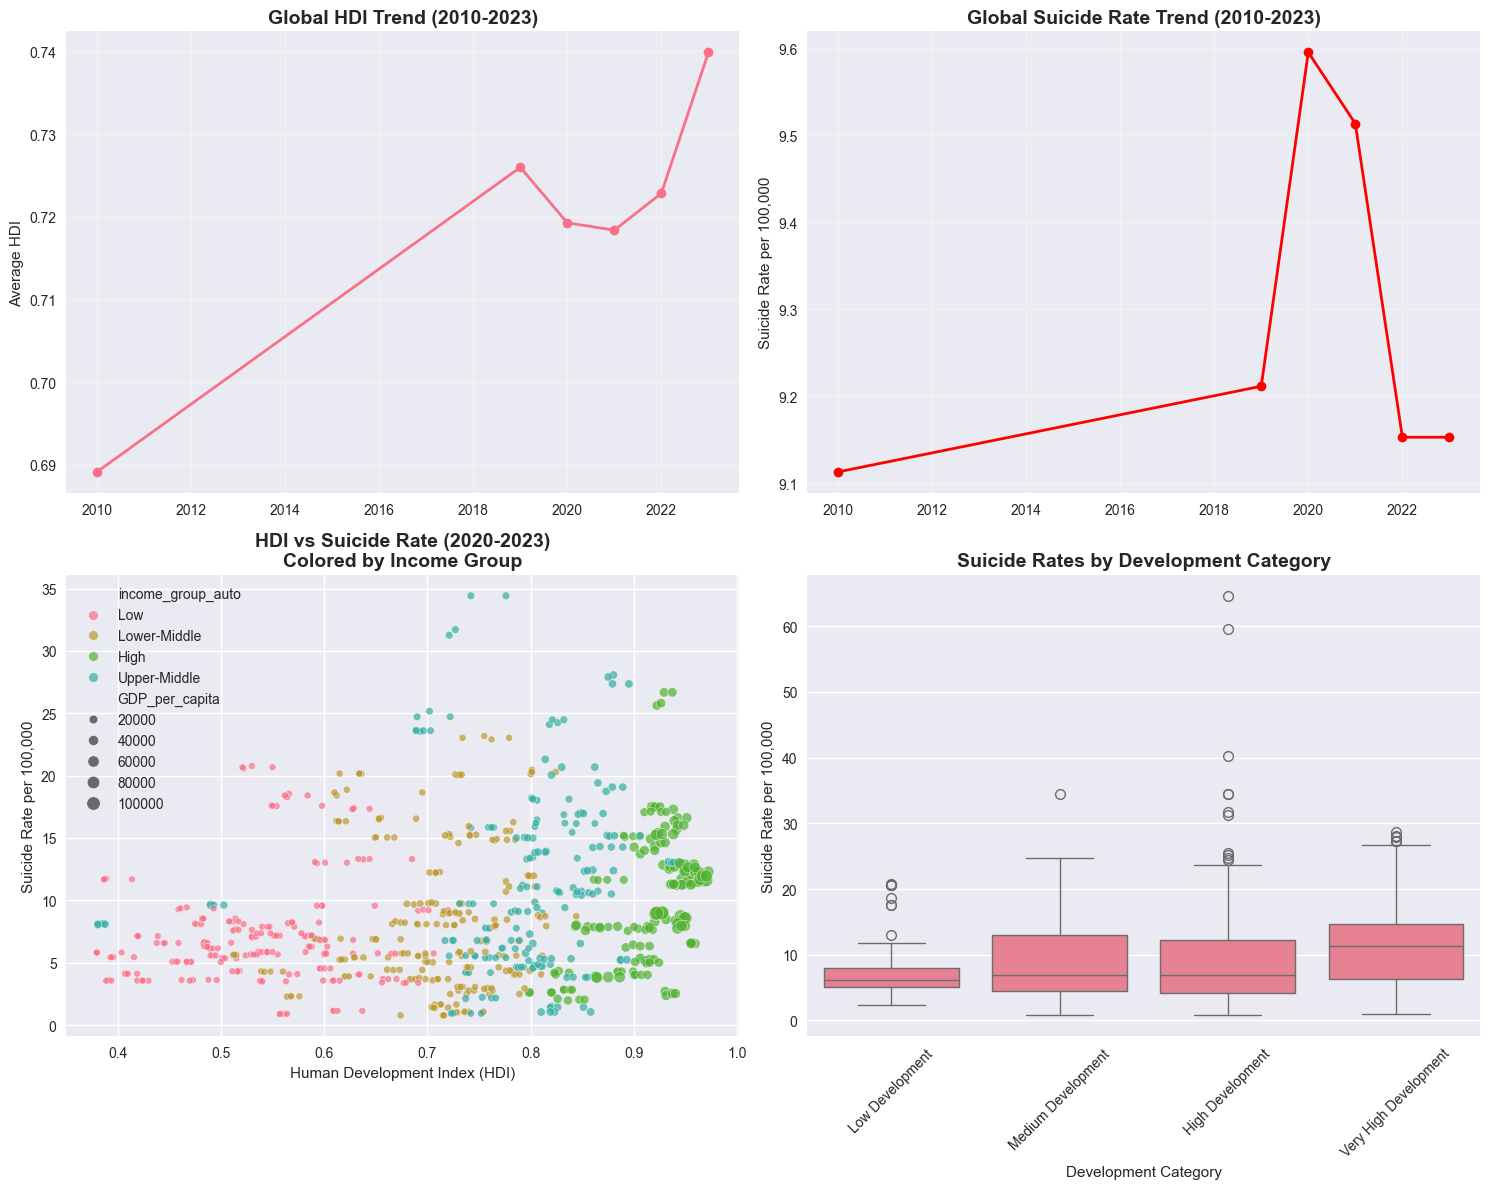

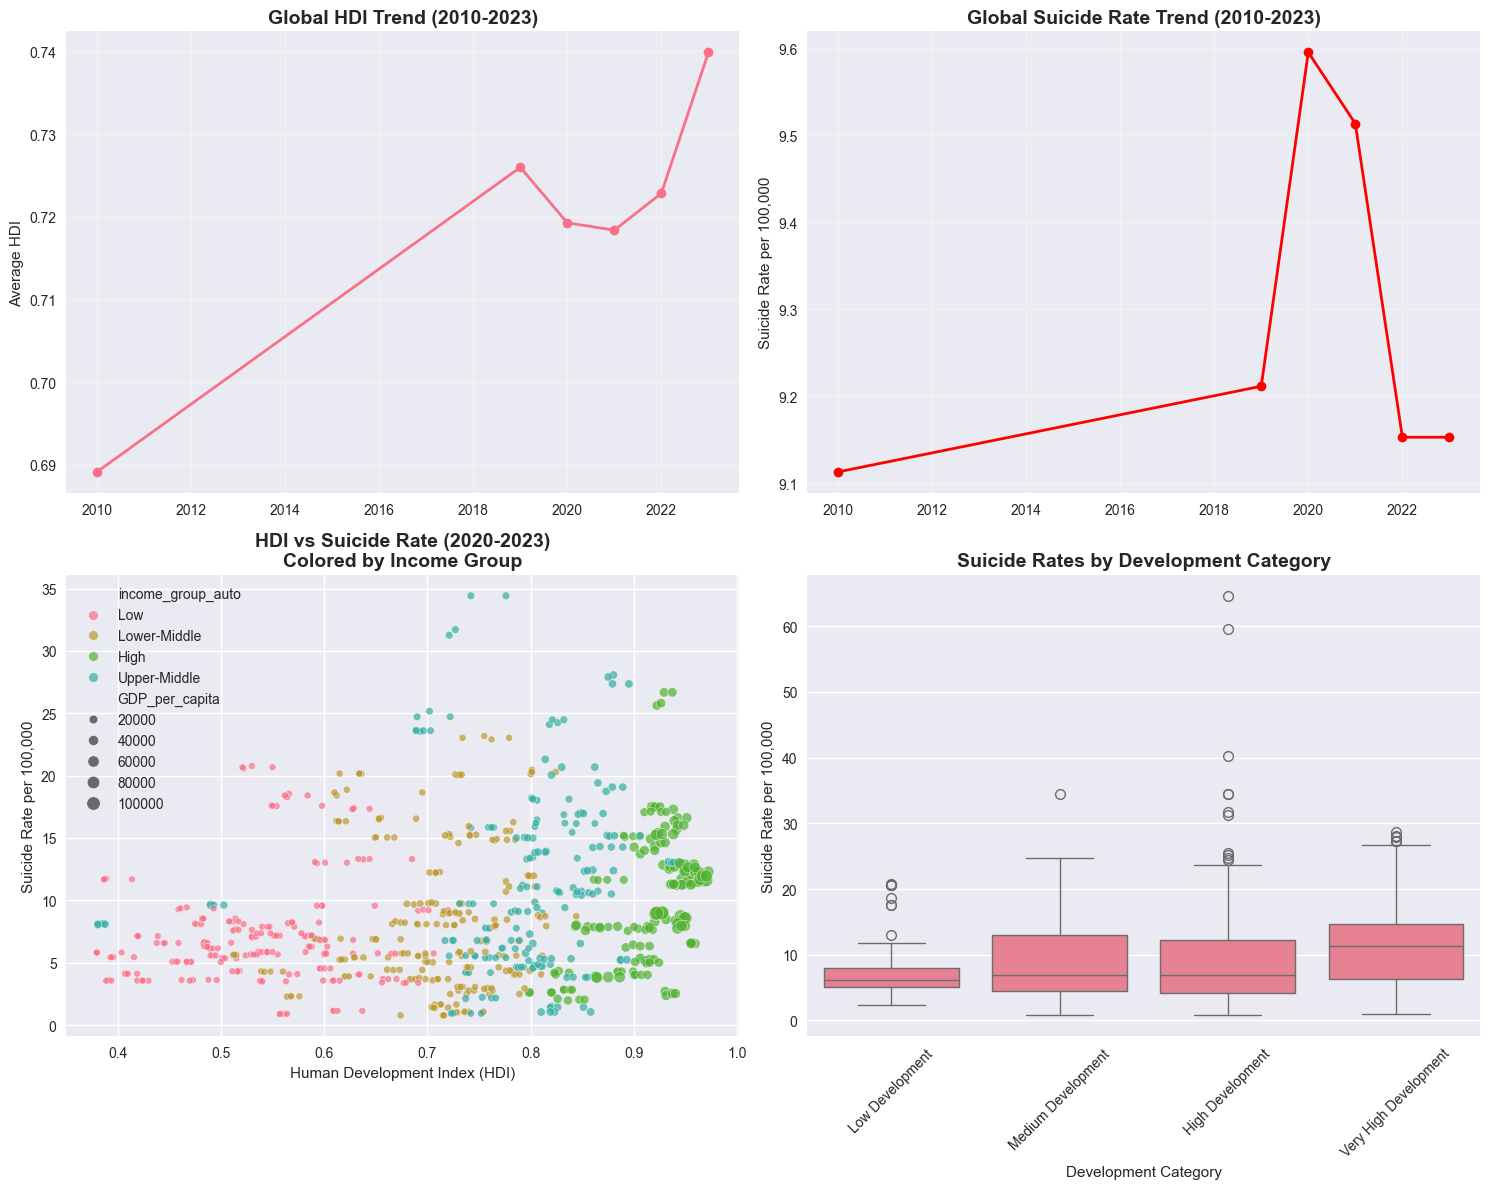

In [10]:
# Step 6: Preliminary EDA for "The Price of Progress" Theme

def preliminary_eda(df_final):
    """
    Generate initial insights for the "Price of Progress" theme
    """
    
    # 1. Global trends over time
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Global HDI trend
    global_hdi = df_final.groupby('Year')['HDI_final'].mean()
    axes[0,0].plot(global_hdi.index, global_hdi.values, marker='o', linewidth=2)
    axes[0,0].set_title('Global HDI Trend (2010-2023)', fontsize=14, fontweight='bold')
    axes[0,0].set_ylabel('Average HDI')
    axes[0,0].grid(True, alpha=0.3)
    
    # Global suicide rate trend
    global_suicide = df_final.groupby('Year')['Suicide_rate_final'].mean()
    axes[0,1].plot(global_suicide.index, global_suicide.values, marker='o', linewidth=2, color='red')
    axes[0,1].set_title('Global Suicide Rate Trend (2010-2023)', fontsize=14, fontweight='bold')
    axes[0,1].set_ylabel('Suicide Rate per 100,000')
    axes[0,1].grid(True, alpha=0.3)
    
    # 2. HDI vs Suicide Rate scatter plot
    recent_data = df_final[df_final['Year'] >= 2020]
    sns.scatterplot(data=recent_data, x='HDI_final', y='Suicide_rate_final', 
                   hue='income_group_auto', size='GDP_per_capita', alpha=0.7, ax=axes[1,0])
    axes[1,0].set_title('HDI vs Suicide Rate (2020-2023)\nColored by Income Group', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('Human Development Index (HDI)')
    axes[1,0].set_ylabel('Suicide Rate per 100,000')
    
    # 3. Suicide rates by development category
    development_order = ['Low Development', 'Medium Development', 'High Development', 'Very High Development']
    sns.boxplot(data=df_final, x='development_category', y='Suicide_rate_final', 
                order=development_order, ax=axes[1,1])
    axes[1,1].set_title('Suicide Rates by Development Category', fontsize=14, fontweight='bold')
    axes[1,1].set_xlabel('Development Category')
    axes[1,1].set_ylabel('Suicide Rate per 100,000')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return fig

preliminary_eda(df_final)

In [11]:
# Step 7: Save the Cleaned Dataset

def save_clean_dataset(df_final):
    """
    Save the final cleaned dataset with documentation
    """
    
    # Select and rename final columns for clarity
    final_columns = {
        'Country Name': 'country',
        'ISO3': 'iso_code',
        'Year': 'year',
        'HDI_final': 'hdi',
        'Suicide_rate_final': 'suicide_rate',
        'GDP_per_capita': 'gdp_per_capita',
        'log_GDP_per_capita': 'log_gdp_per_capita',
        'income_group_auto': 'income_group',
        'continent': 'continent',
        'data_quality_score': 'data_quality_score',
        'development_category': 'development_category',
        'suicide_category': 'suicide_category',
        'hdi_change_5yr': 'hdi_change_5yr',
        'suicide_change_5yr': 'suicide_change_5yr',
        'gdp_percentile': 'gdp_percentile',
        'progress_paradox': 'progress_paradox',
        'regional_hdi_avg': 'regional_hdi_avg',
        'regional_suicide_avg': 'regional_suicide_avg'
    }
    
    df_export = df_final[list(final_columns.keys())].rename(columns=final_columns)
    
    # Add metadata about the cleaning process
    metadata = {
        'cleaning_approach': 'Ethical preservation with hierarchical imputation',
        'missing_data_handling': 'Country -> Regional -> Income group -> Global averages',
        'data_quality_note': 'Higher data_quality_score indicates more imputation used',
        'project_theme': 'The Price of Progress - HDI, Economic Growth vs Suicide Rates',
        'timestamp': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
        'total_countries': df_export['country'].nunique(),
        'time_period': f"{df_export['year'].min()}-{df_export['year'].max()}",
        'total_records': len(df_export)
    }
    
    # Save to CSV
    df_export.to_csv('final_clean_dataset.csv', index=False)
    
    # Save metadata separately
    with open('dataset_metadata.txt', 'w') as f:
        for key, value in metadata.items():
            f.write(f"{key}: {value}\n")
    
    print("✅ Clean dataset saved as 'final_clean_dataset.csv'")
    print("✅ Metadata saved as 'dataset_metadata.txt'")
    print(f"📊 Final dataset shape: {df_export.shape}")
    print(f"🌍 Countries: {df_export['country'].nunique()}")
    print(f"📅 Years: {df_export['year'].min()} - {df_export['year'].max()}")
    
    return df_export

final_dataset = save_clean_dataset(df_final)

✅ Clean dataset saved as 'final_clean_dataset.csv'
✅ Metadata saved as 'dataset_metadata.txt'
📊 Final dataset shape: (1175, 18)
🌍 Countries: 205
📅 Years: 2010 - 2023


In [12]:
# Step 8: Generate Initial "Wow" Insights

def generate_initial_insights(df_final):
    """
    Generate compelling insights for the "Price of Progress" theme
    """
    
    print("=== INITIAL 'WOW' INSIGHTS ===")
    
    # Insight 1: The Development Paradox
    recent_data = df_final[df_final['Year'] == 2021]
    paradox_countries = recent_data[
        recent_data['progress_paradox'] == 1
    ]['Country Name'].unique()
    
    print(f"🔍 INSIGHT 1: The Development Paradox")
    print(f"   {len(paradox_countries)} countries show both high HDI AND high suicide rates")
    print(f"   Examples: {', '.join(paradox_countries[:10])}")
    
    # Insight 2: Regional patterns
    regional_patterns = recent_data.groupby('continent').agg({
        'HDI_final': 'mean',
        'Suicide_rate_final': 'mean'
    }).round(3)
    
    print(f"\n🌎 INSIGHT 2: Regional Development-Suicide Patterns")
    for continent in regional_patterns.index:
        hdi = regional_patterns.loc[continent, 'HDI_final']
        suicide = regional_patterns.loc[continent, 'Suicide_rate_final']
        print(f"   {continent}: HDI {hdi}, Suicide Rate {suicide}")
    
    # Insight 3: Income group analysis
    income_analysis = recent_data.groupby('income_group').agg({
        'HDI_final': 'mean',
        'Suicide_rate_final': 'mean',
        'GDP_per_capita': 'mean'
    }).round(2)
    
    print(f"\n💰 INSIGHT 3: The Income Group Divide")
    for income_group in ['Low', 'Lower-Middle', 'Upper-Middle', 'High']:
        if income_group in income_analysis.index:
            data = income_analysis.loc[income_group]
            print(f"   {income_group}: HDI {data['HDI_final']}, "
                  f"Suicide {data['Suicide_rate_final']}, GDP ${data['GDP_per_capita']:,.0f}")
    
    # Insight 4: Change over time
    country_changes = df_final.groupby('Country Name').agg({
        'hdi_change_5yr': 'last',
        'suicide_change_5yr': 'last'
    }).dropna()
    
    improving_but_worsening_suicide = country_changes[
        (country_changes['hdi_change_5yr'] > 0) & 
        (country_changes['suicide_change_5yr'] > 0)
    ]
    
    print(f"\n📈 INSIGHT 4: Progress with a Cost")
    print(f"   {len(improving_but_worsening_suicide)} countries improved HDI but saw rising suicide rates")
    
    # Insight 5: Most improved vs suicide trends
    top_improvers = country_changes.nlargest(5, 'hdi_change_5yr')
    print(f"\n🏆 INSIGHT 5: Top HDI Improvers vs Suicide Trends")
    for country in top_improvers.index:
        hdi_change = top_improvers.loc[country, 'hdi_change_5yr']
        suicide_change = top_improvers.loc[country, 'suicide_change_5yr']
        trend = "↑ worsening" if suicide_change > 0 else "↓ improving"
        print(f"   {country}: HDI +{hdi_change:.3f}, Suicide {suicide_change:+.2f} ({trend})")
    
    return paradox_countries

generate_initial_insights(df_final)

=== INITIAL 'WOW' INSIGHTS ===
🔍 INSIGHT 1: The Development Paradox
   57 countries show both high HDI AND high suicide rates
   Examples: Andorra, Argentina, Australia, Austria, Belgium, Bulgaria, Bosnia and Herzegovina, Belarus, Canada, Switzerland

🌎 INSIGHT 2: Regional Development-Suicide Patterns
   Africa: HDI 0.553, Suicide Rate 7.417
   America: HDI 0.754, Suicide Rate 8.508
   Asia: HDI 0.744, Suicide Rate 6.534
   Europe: HDI 0.878, Suicide Rate 13.013
   Oceania: HDI 0.709, Suicide Rate 14.234


KeyError: 'income_group'

In [ ]:
# Final Summary

print("🎯 PROJECT SUMMARY: 'The Price of Progress'")
print("="*50)
print("✅ DATA CLEANING COMPLETED")
print(f"   - Original dataset: {df.shape}")
print(f"   - Cleaned dataset: {final_dataset.shape}")
print(f"   - Countries preserved: {final_dataset['country'].nunique()}")
print(f"   - Time period: {final_dataset['year'].min()}-{final_dataset['year'].max()}")

print("\n🔍 KEY FEATURES CREATED")
print("   - development_category: Categorical HDI levels")
print("   - suicide_category: Categorical suicide rate levels") 
print("   - progress_paradox: Flags high HDI + high suicide countries")
print("   - hdi_change_5yr: 5-year HDI change")
print("   - data_quality_score: Transparency in data quality")

print("\n📊 READY FOR ANALYSIS")
print("   The dataset is now ready for exploring:")
print("   • Relationships between development and mental health")
print("   • Regional and income-based patterns")
print("   • Temporal trends and paradoxes")
print("   • Ethical implications of progress")

print("\n💡 NEXT STEPS:")
print("   1. Deep dive into 'progress_paradox' countries")
print("   2. Analyze regional variations")
print("   3. Build predictive models")
print("   4. Create interactive visualizations")